# Capstone Project 20.1: Initial Report and Exploratory Data Analysis (EDA) 

# 1. Introduction

This notebook analyzes a dataset of hotel reviews from TripAdvisor, consisting of user-generated feedback and corresponding ratings on a scale from 1 to 5. The dataset includes two key features: the text of the review, which captures the user's experience, and the numerical rating, which reflects their overall satisfaction (1 being very negative and 5 being very positive). The goal is to build a machine learning model that predicts a review's rating based on its text and to gain insights into the sentiment expressed in the reviews.

The workflow begins with data preprocessing, where the reviews are cleaned, normalized, and tokenized. Noise such as punctuation, stop words, and domain-specific terms is removed to focus on meaningful content. The processed text is then transformed into numerical features using TF-IDF (Term Frequency-Inverse Document Frequency). To address potential class imbalance in the dataset, oversampling techniques like ADASYN are applied. Several machine learning models, including Naive Bayes, Logistic Regression, Random Forest, and Support Vector Machines (SVM), are trained and evaluated using metrics such as accuracy, precision, recall, and F1-score. Hyperparameter tuning with GridSearchCV is used to optimize model performance.

Finally, the trained models are validated using synthetic reviews that simulate good, neutral, and bad experiences. This approach ensures the models' predictions align with expected outcomes. The results of this analysis have practical applications in the hospitality industry, such as automating feedback analysis, identifying frequent customer concerns, and using insights to improve services. By the end of this notebook, we aim to provide a reliable predictive model and actionable insights into customer feedback.

### ChatGPT 4o was used to create code for this project.

# 2. Importing Libraries and Preparing the Environment

This section of the code sets up the environment for performing data preprocessing, natural language processing (NLP), machine learning, and visualization. Below is a breakdown of the key components:

In [1]:
# Standard Library Imports
import time
import re

# Numerical and Data Manipulation Libraries
import numpy as np
import pandas as pd

# Natural Language Processing Libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from spellchecker import SpellChecker
from symspellpy import SymSpell, Verbosity
import pycountry

# Machine Learning Libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

# Import additional models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Import SMOTE & ADASYN
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Parallel Processing Libraries
from pandarallel import pandarallel

# Other Libraries
import pkg_resources
from collections import Counter

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Load dataset
df = pd.read_csv('data/tripadvisor_hotel_reviews.csv')


[nltk_data] Downloading package punkt to /home/mark/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/mark/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/mark/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# 3. Understanding the Data

In [2]:
# Understanding the Data
df.head()  # Display first few rows of data

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


## 3.1 Convert from 5 Rating to 3

To improve classification performance, the scope has been reduced from 5 rating levels to 3 categories:

    5: Positive Review
    3: Neutral Review
    1: Negative Review

This was achieved by merging ratings, with all 4 ratings converted to 5 and all 2 ratings converted to 1.

In [3]:
# Replace 4 with 5 and 2 with 1 in the 'Rating' column
df['Rating'] = df['Rating'].replace({4: 5, 2: 1})
df.head()  # Display first few rows of data

,Review,Rating
0,nice hotel expensive parking got good deal sta...,5
1,ok nothing special charge diamond member hilto...,1
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [4]:
df.info()  # Check for missing values, data types, etc.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB


In [5]:
df.describe()  # Descriptive statistics of numerical columns

,Rating
count,20491.000000
mean,4.159436
std,1.493146
min,1.000000
25%,3.000000
50%,5.000000
75%,5.000000
max,5.000000


# 4. Outlier Removal

This section of the code is focused on identifying and removing outliers from the dataset based on the length of the reviews. Here's what each line does:

In [6]:
# Outlier Removal
df['word_count'] = df['Review'].str.split().apply(len)
df['text_length'] = df['Review'].str.len()

# Removing reviews with outliers based on text length and word count (e.g., reviews longer than 95th percentile)
word_count_threshold = df['word_count'].quantile(0.95)
df = df[df['word_count'] <= word_count_threshold]

# Display the first few rows after outlier removal
df.head()


,Review,Rating,word_count,text_length
0,nice hotel expensive parking got good deal sta...,5,87,593
1,ok nothing special charge diamond member hilto...,1,250,1689
2,nice rooms not 4* experience hotel monaco seat...,3,217,1427
3,"unique, great stay, wonderful time hotel monac...",5,89,600
4,"great stay great stay, went seahawk game aweso...",5,191,1281


# 5. Visualizing Review Word Count, Text Length, and Rating Distributions

This section of the code is focused on visualizing key characteristics of the dataset, including the distribution of review word counts, text lengths, and ratings. It uses matplotlib and seaborn for creating the plots.

A key finding here is that this is not a balanced dataset.

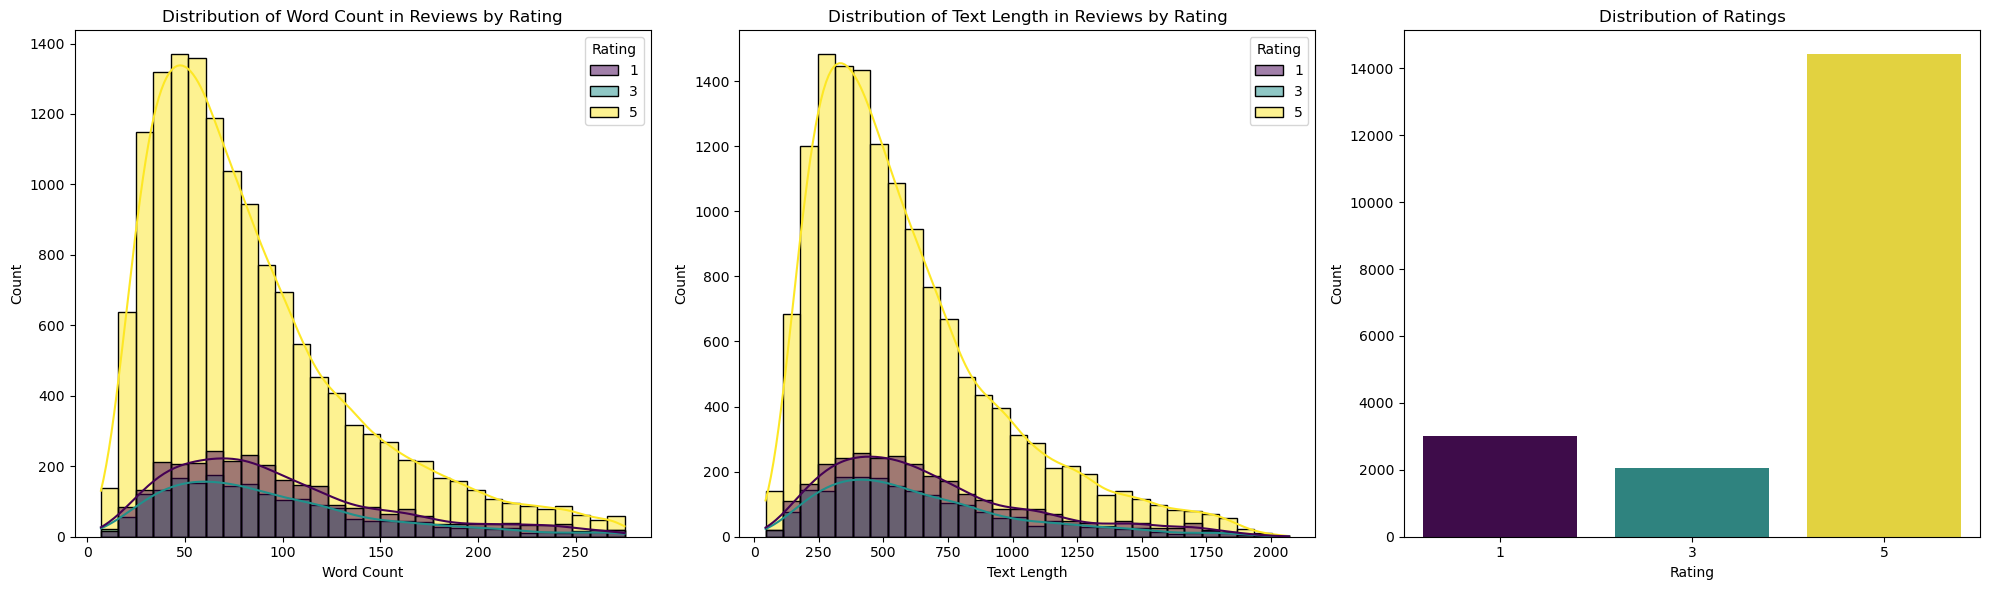

In [7]:
# Review Word Count, Text Length, and Rating Distributions

def plot_review_distributions(df):
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    
    sns.histplot(
        df, x='word_count', bins=30, ax=axes[0], kde=True, hue='Rating', palette='viridis'
    )
    axes[0].set_title('Distribution of Word Count in Reviews by Rating')
    axes[0].set_xlabel('Word Count')
    
    sns.histplot(
        df, x='text_length', bins=30, ax=axes[1], kde=True, hue='Rating', palette='viridis'
    )
    axes[1].set_title('Distribution of Text Length in Reviews by Rating')
    axes[1].set_xlabel('Text Length')
    
    # Modify the countplot
    sns.countplot(
        data=df, x='Rating', hue='Rating', palette='viridis', ax=axes[2]
    )
    axes[2].set_title('Distribution of Ratings')
    axes[2].set_xlabel('Rating')
    axes[2].set_ylabel('Count')
    
    # Remove the legend as it's redundant
    axes[2].legend_.remove()
    
    plt.tight_layout()
    plt.show()

# Call the function to visualize word count, text length, and rating distributions
plot_review_distributions(df)

# 6. Missing Value Analysis

This section of the code performs a missing value analysis on the dataset to identify and handle any missing or null values.

In [8]:
# Missing Value Analysis
df.isnull().sum()  # Check for missing values

Review         0
Rating         0
word_count     0
text_length    0
dtype: int64

# 7. Spell Checking and Parallel Processing

This section of the code applies spell checking to a dataset of hotel reviews using the SymSpell algorithm for high-speed spell correction. The process is parallelized using pandarallel to improve efficiency, especially when working with large datasets.

In [9]:
# Initialize pandarallel
pandarallel.initialize(progress_bar=True)

# Initialize SymSpell
sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
dictionary_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_dictionary_en_82_765.txt"
)
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)
bigram_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_bigramdictionary_en_243_342.txt"
)
sym_spell.load_bigram_dictionary(bigram_path, term_index=0, count_index=2)

# Add custom words
custom_words = ['tripadvisor', 'wifi', 'lobby', 'spa', 'concierge', 'cozy'
                #,'1*','2*','3*','4*','5*'
               ]
for word in custom_words:
    sym_spell.create_dictionary_entry(word, 1)

# Define spell-check function
def spell_check_review(review):
    suggestions = sym_spell.lookup_compound(review, max_edit_distance=2)
    if suggestions:
        corrected_review = suggestions[0].term
    else:
        corrected_review = review
    return corrected_review

# Apply spell checking in parallel
df['corrected_review'] = df['Review'].parallel_apply(spell_check_review)

# Verify the results
print(df[['Review', 'corrected_review']].head(10))

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


                                              Review  \
0  nice hotel expensive parking got good deal sta...   
1  ok nothing special charge diamond member hilto...   
2  nice rooms not 4* experience hotel monaco seat...   
3  unique, great stay, wonderful time hotel monac...   
4  great stay great stay, went seahawk game aweso...   
5  love monaco staff husband stayed hotel crazy w...   
6  cozy stay rainy city, husband spent 7 nights m...   
7  excellent staff, housekeeping quality hotel ch...   
8  hotel stayed hotel monaco cruise, rooms genero...   
9  excellent stayed hotel monaco past w/e delight...   

                                    corrected_review  
0  nice hotel expensive parking got good deal sta...  
1  of nothing special charge diamond member hilto...  
2  nice rooms not a experience hotel monaco seatt...  
3  unique great stay wonderful time hotel monaco ...  
4  great stay great stay went sea hawk game aweso...  
5  love monaco staff husband stayed hotel crazy w... 

In [10]:
df.head(10)

,Review,Rating,word_count,text_length,corrected_review
0,nice hotel expensive parking got good deal sta...,5,87,593,nice hotel expensive parking got good deal sta...
1,ok nothing special charge diamond member hilto...,1,250,1689,of nothing special charge diamond member hilto...
2,nice rooms not 4* experience hotel monaco seat...,3,217,1427,nice rooms not a experience hotel monaco seatt...
3,"unique, great stay, wonderful time hotel monac...",5,89,600,unique great stay wonderful time hotel monaco ...
4,"great stay great stay, went seahawk game aweso...",5,191,1281,great stay great stay went sea hawk game aweso...
5,love monaco staff husband stayed hotel crazy w...,5,134,1002,love monaco staff husband stayed hotel crazy w...
6,"cozy stay rainy city, husband spent 7 nights m...",5,101,748,cozy stay rainy city husband spent a nights mo...
7,"excellent staff, housekeeping quality hotel ch...",5,85,597,excellent staff housekeeping quality hotel cho...
8,"hotel stayed hotel monaco cruise, rooms genero...",5,59,419,hotel stayed hotel monaco cruise rooms generou...
9,excellent stayed hotel monaco past w/e delight...,5,35,271,excellent stayed hotel monaco past we delight ...


# 8. Adding Domain-Specific Stop Words

This section of the code defines and updates a custom set of stop words (domain_stop_words) that are specific to the domain of hotel reviews. These additional stop words help refine text preprocessing by removing words that are less meaningful for analysis and modeling.

In [11]:
# Add domain-specific stop words
domain_stop_words = set([])

# Get list of country names
countries = [country.name.lower() for country in pycountry.countries]

# Include common alternative names and abbreviations
additional_countries = [
    'usa', 'us', 'uk', 'united states', 'united kingdom', 'america', 'england',
    'scotland', 'wales', 'northern ireland', 'uae', 'united arab emirates',
    'south korea', 'north korea', 'czech republic', 'slovakia'
]

# Add hotel stop words

hotel_stop_words = ['stayed','good','room','hotel','night','day','stay','breakfast','restaurant','staff']

# Experiment with these hotel stop words
'''
hotel_stop_words = [
    'like', 'clean','husband','wife','went','hour','minute','great','beach','good','buffet','city','star','water','trip','resort','nt','got','hotel',
    'hotels', 'room', 'rooms', 'stay', 'stayed', 'staying', 'check-in', 'check-out','am','pm', 'really',
    'lobby', 'staff', 'service', 'services', 'reservation', 'booking', 'night', 'nights','day', 'days',
    'bed', 'beds', 'bathroom', 'bathrooms', 'floor', 'floors', 'guest', 'guests',
    'visit', 'visited', 'location', 'area', 'place', 'property', 'building', 'facilities',
    'amenities', 'reception', 'desk', 'price', 'cost', 'charge', 'charges', 'rate', 'rates',
    'manager', 'management', 'experience', 'experiences', 'time', 'times', 'parking',
    'breakfast', 'dinner', 'lunch', 'food', 'restaurant', 'restaurants', 'bar', 'bars',
    'pool', 'pools', 'spa', 'gym', 'fitness', 'internet', 'wifi', 'view', 'views',
    'air conditioning', 'ac', 'heater', 'heating', 'television', 'tv', 'phone', 'phones',
    'luggage', 'baggage', 'shower', 'towels',
    'people', 'person', 'thing', 'things', 'day', 'days', 'year', 'years', 'week', 'weeks',
    'hilton', 'marriott', 'sheraton', 'hyatt', 'holiday inn', 'best western', 'intercontinental',
    'accor', 'motel', 'inn', 'suites', 'monday','tuesday','wednesday','thursday','friday','saturday',
    'sunday','january','february','march','april','may','june','july','august','september','october',
    'november','december'
]
'''   
# List of popular holiday destinations
holiday_destinations = [
    'paris', 'london', 'new york', 'tokyo', 'dubai', 'singapore', 'barcelona',
    'rome', 'bali', 'bangkok', 'amsterdam', 'sydney', 'las vegas', 'hong kong',
    'los angeles', 'istanbul', 'milan', 'vienna', 'prague', 'miami', 'seoul',
    'san francisco', 'orlando', 'rio de janeiro', 'cape town', 'moscow',
    'beijing', 'cancun', 'dublin', 'toronto', 'florence', 'venice', 'madrid',
    'chiang mai', 'edmonton', 'montreal', 'copenhagen', 'zurich', 'geneva',
    'shanghai', 'kuala lumpur', 'seville', 'marrakech', 'santorini',
    'mykonos', 'lisbon', 'budapest', 'krakow', 'nice', 'cairo', 'jerusalem',
    'berlin', 'munich', 'brussels', 'athens', 'stockholm', 'oslo', 'helsinki',
    'auckland', 'melbourne', 'honolulu', 'philadelphia', 'atlanta', 'chicago',
    'san diego', 'seattle', 'houston', 'dallas', 'boston', 'washington dc',
    'nashville', 'new orleans', 'savannah', 'charleston', 'portland',
    'vancouver', 'mexico city', 'sao paulo', 'lima', 'bogota', 'buenos aires',
    'santiago', 'manila', 'hanoi', 'ho chi minh city', 'phuket', 'koh samui',
    'siem reap', 'macao', 'taipei', 'delhi', 'mumbai', 'jaipur', 'goa',
    'agra', 'colombo', 'male', 'doha', 'riyadh', 'amman', 'doha', 'sofia',
    'bucharest', 'belgrade', 'zagreb', 'ljubljana', 'tallinn', 'riga',
    'vilnius', 'luxembourg', 'monaco', 'andorra', 'reykjavik', 'antigua',
    'barbados', 'bahamas', 'jamaica', 'dominican republic', 'puerto vallarta',
    'cabo san lucas', 'hawaii', 'fiji', 'maldives', 'seychelles', 'mauritius'
    'seattle','amsterdam','europe','asia','schipol'
]
# List of US states and territories
us_states = [
    'alabama', 'alaska', 'arizona', 'arkansas', 'california', 'colorado',
    'connecticut', 'delaware', 'florida', 'georgia', 'hawaii', 'idaho',
    'illinois', 'indiana', 'iowa', 'kansas', 'kentucky', 'louisiana', 'maine',
    'maryland', 'massachusetts', 'michigan', 'minnesota', 'mississippi',
    'missouri', 'montana', 'nebraska', 'nevada', 'new hampshire', 'new jersey',
    'new mexico', 'new york', 'north carolina', 'north dakota', 'ohio',
    'oklahoma', 'oregon', 'pennsylvania', 'rhode island', 'south carolina',
    'south dakota', 'tennessee', 'texas', 'utah', 'vermont', 'virginia',
    'washington', 'west virginia', 'wisconsin', 'wyoming',
    # Territories
    'puerto rico', 'guam', 'american samoa', 'u.s. virgin islands', 'northern mariana islands'
]

# Common abbreviations
us_states_abbreviations = [
    'al', 'ak', 'az', 'ar', 'ca', 'co', 'ct', 'de', 'fl', 'ga', 'hi', 'id',
    'il', 'in', 'ia', 'ks', 'ky', 'la', 'me', 'md', 'ma', 'mi', 'mn', 'ms',
    'mo', 'mt', 'ne', 'nv', 'nh', 'nj', 'nm', 'ny', 'nc', 'nd', 'oh', 'ok',
    'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'vt', 'va', 'wa', 'wv',
    'wi', 'wy',
    # Territories abbreviations
    'pr', 'gu', 'as', 'vi', 'mp'
]

# Update domain_stop_words with all new terms
domain_stop_words.update(countries)
domain_stop_words.update(additional_countries)
domain_stop_words.update(hotel_stop_words)
domain_stop_words.update(holiday_destinations)
domain_stop_words.update(us_states)
domain_stop_words.update(us_states_abbreviations)

# 9. Text Preprocessing and Analyzing Top Words for Each Rating

This section of the code performs text preprocessing on hotel reviews and identifies the most common words for each rating. 

Why This Step is Important

    Text Preprocessing:
        Ensures the data is clean and consistent for analysis or modeling.
        Removes irrelevant words (stop words) and standardizes word forms (lemmatization).

    Exploratory Analysis:
        Identifying top words for each rating provides insights into the language used in positive and negative reviews.
        Can reveal common themes (e.g., "clean," "friendly" for high ratings; "dirty," "rude" for low ratings).

    Feature Engineering:
        The top words can be used as features in machine learning models to predict ratings.
        Helps focus on words that are most indicative of user sentiment.

In [12]:
# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Define standard stop words
stop_words = set(stopwords.words('english'))

# Combine all stop words
all_stop_words = stop_words.union(domain_stop_words)

def preprocess_text(text):
    if not isinstance(text, str):
        return "", []  # Handle non-string inputs gracefully

    # Normalize text
    text = text.lower()
    text = text.replace('*', 'star')  # Replace asterisks with 'star'
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation

    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove stop words
    tokens = [word for word in tokens if word not in all_stop_words]

    # Lemmatization
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Rejoin tokens into text
    preprocessed_text = ' '.join(tokens)

    return preprocessed_text, tokens  # Return both preprocessed text and tokens

# Apply preprocessing to the 'corrected_review' column and assign to 'cleaned_review' and 'tokens'
df[['cleaned_review', 'tokens']] = df['corrected_review'].apply(
    lambda x: pd.Series(preprocess_text(x))
)

# Verify the assignment
print(df[['cleaned_review', 'tokens']].head())

# Display the top words in each rating after preprocessing
top_words_per_rating = {}

# Loop through each unique rating in the DataFrame
for rating in sorted(df['Rating'].unique()):
    # Subset the DataFrame to include only reviews with the current rating
    df_rating = df[df['Rating'] == rating]

    # Combine all tokens in this rating into a single list
    tokens = [token for tokens_list in df_rating['tokens'] for token in tokens_list]

    # Count word frequencies using Counter
    word_counts = Counter(tokens)

    # Get the top 20 most common words and their counts
    top_words = word_counts.most_common(20)

    # Store the results in the dictionary
    top_words_per_rating[rating] = top_words


                                      cleaned_review  \
0  expensive parking got deal anniversary arrived...   
1  nothing special charge diamond member hilton d...   
2  room experience level positive large bathroom ...   
3  unique great wonderful time location excellent...   
4  great great went sea hawk game awesome downfal...   

                                              tokens  
0  [expensive, parking, got, deal, anniversary, a...  
1  [nothing, special, charge, diamond, member, hi...  
2  [room, experience, level, positive, large, bat...  
3  [unique, great, wonderful, time, location, exc...  
4  [great, great, went, sea, hawk, game, awesome,...  


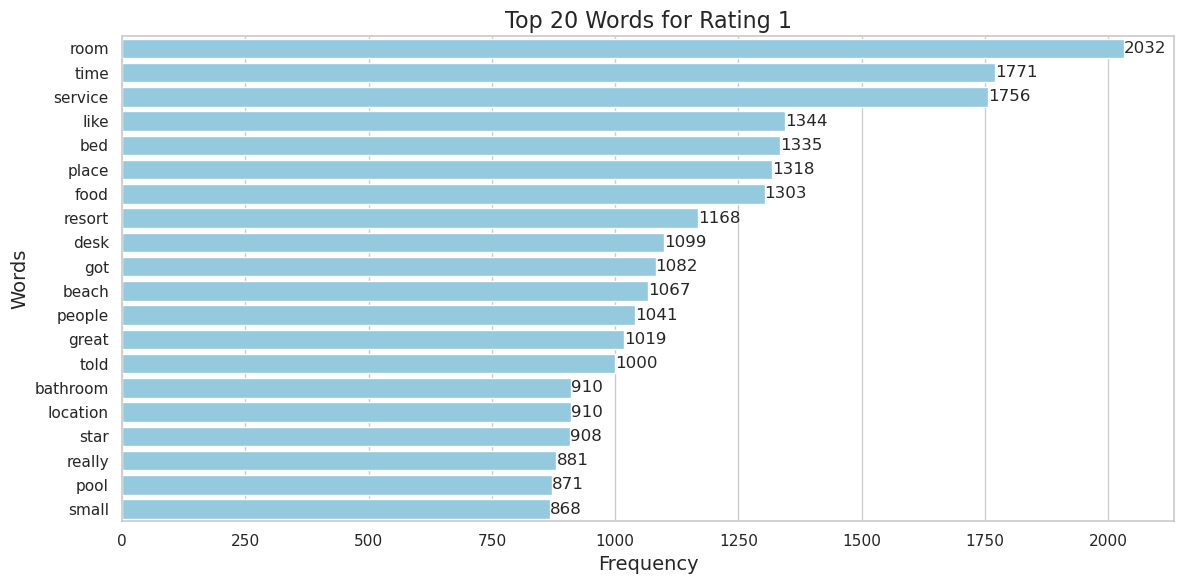

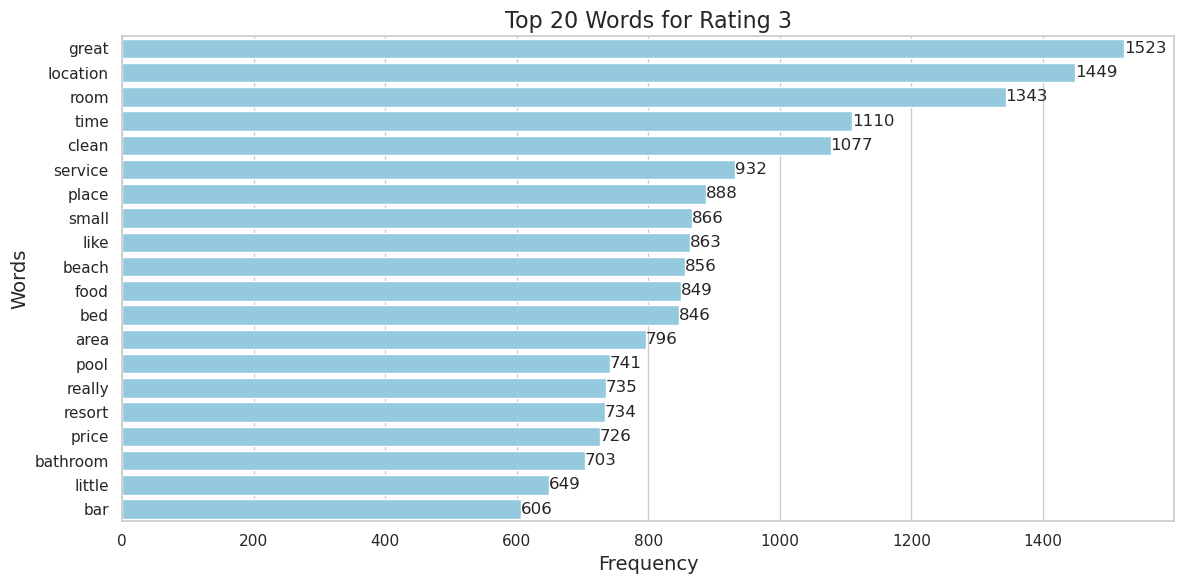

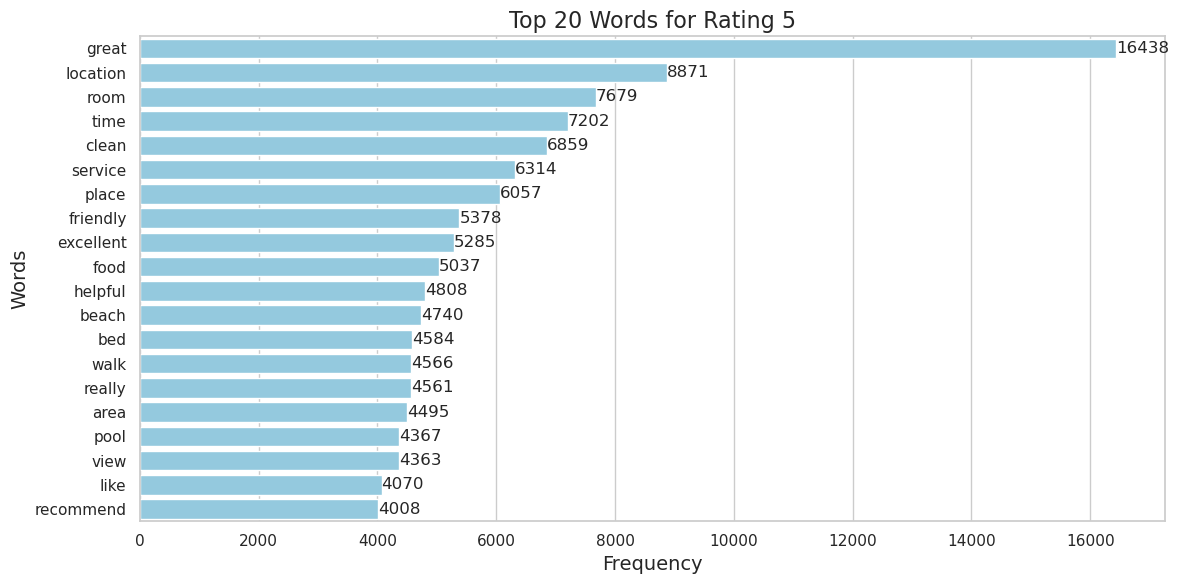

In [13]:
sns.set_theme(style="whitegrid")

# Visualization: Sorted Bar Charts with Data Labels
for rating, words in top_words_per_rating.items():
    words_df = pd.DataFrame(words, columns=['Word', 'Count']).sort_values(by='Count', ascending=False)
    
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x='Count', y='Word', data=words_df, color='skyblue')
    plt.title(f'Top 20 Words for Rating {rating}', fontsize=16)
    plt.xlabel('Frequency', fontsize=14)
    plt.ylabel('Words', fontsize=14)
    
    # Add data labels
    for p in ax.patches:
        ax.annotate(format(p.get_width(), '.0f'),
                    (p.get_width()+0.1, p.get_y() + p.get_height()/2.),
                    ha='left', va='center')
    
    plt.tight_layout()
    plt.show()


# 10. Preparing Data for Modeling

This step prepares the dataset for machine learning by separating the input features (independent variables) from the target variable (dependent variable).

In [14]:
# Prepare data for modeling
X = df['cleaned_review']
y = df['Rating']

# 11. TF-IDF Feature Extraction and Train-Test Split

This section transforms the textual data into numerical features using TF-IDF (Term Frequency-Inverse Document Frequency) and splits the dataset into training and testing sets for model evaluation.

In [15]:
# TF-IDF Feature Extraction
tfidf = TfidfVectorizer(max_features=10000, min_df=2)
X_tfidf = tfidf.fit_transform(X)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.3, random_state=42, stratify=y
)

# 12. Applying Feature Scaling to the Training and Testing Sets

This step ensures that the numerical features in the dataset are scaled to a standard range, which is often necessary for certain machine learning algorithms (e.g., Support Vector Machines with RBF kernel or models sensitive to feature magnitudes).

In [16]:
# Apply scaling to the training and testing sets
scaler = StandardScaler(with_mean=False)  # Sparse matrix compatibility
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 13. Addressing Class Imbalance with SMOTE / ADASYN

This section of the code uses the ADASYN (Adaptive Synthetic Sampling) technique to address class imbalance in the training dataset. By generating synthetic samples for the minority classes, this method helps improve model performance on imbalanced datasets.

In [17]:
# Apply SMOTE to training data
# smote = SMOTE(random_state=42)
# X_train_resampled , y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Apply ADASYN to training data
adasyn = ADASYN(random_state=42)
X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train_scaled, y_train)

# 14. Defining Models and Hyperparameter Tuning Parameters¶

This section of the code initializes a set of machine learning models and their respective hyperparameter grids for tuning. These models will be trained and evaluated to identify the best-performing model and its optimal hyperparameters.

In [18]:
# Define models and parameters for hyperparameter tuning
models = {
    'Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
}

param_grids = {
    'Naive Bayes': {'alpha': [0.1, 0.5, 1.0, 5.0, 10.0]},
    'Logistic Regression': {'C': [0.01, 0.1, 1.0, 10.0, 100.0]},
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10]
    },
    'K-Nearest Neighbors': {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    },
}

# 15. Model Training and Evaluation with Time Measurement

This section of the code performs the following tasks for multiple machine learning models:

    Trains each model using Grid Search for hyperparameter tuning.
    Measures the time taken for training each model.
    Evaluates the models on the test set and records their performance metrics.
    Displays classification reports for each model.

In [19]:
# Model Training and Evaluation with Time Measurement
results = []
best_models = {}

for model_name, model in models.items():
    print(f"\nTraining {model_name}...")
    
    # Start time
    start_time = time.time()
    
    # Grid Search for hyperparameter tuning
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grids[model_name],
        cv=3,
        scoring='f1_weighted',
        n_jobs=-1
    )
    grid_search.fit(X_train_resampled, y_train_resampled)
    
    # Retrieve the best model
    best_model = grid_search.best_estimator_
    best_models[model_name] = best_model  # Store the best model
    
    # End time
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Time taken for {model_name}: {elapsed_time:.2f} seconds")
    
    # Evaluate on the test set
    y_pred = best_model.predict(X_test_scaled)
    report = classification_report(y_test, y_pred, output_dict=True)
    
    # Append results including Best Hyperparameters
    results.append({
        'Model': model_name,
        'Accuracy': report['accuracy'],
        'Time (s)': elapsed_time,
        'Best Hyperparameters': grid_search.best_params_
    })
    
    print(f"Classification Report for {model_name}:")
    print(classification_report(y_test, y_pred))
    print("-" * 50)




Training Naive Bayes...
Time taken for Naive Bayes: 1.68 seconds
Classification Report for Naive Bayes:
              precision    recall  f1-score   support

           1       0.62      0.63      0.63       901
           3       0.21      0.24      0.22       616
           5       0.87      0.85      0.86      4325

    accuracy                           0.75      5842
   macro avg       0.57      0.57      0.57      5842
weighted avg       0.76      0.75      0.76      5842

--------------------------------------------------

Training Logistic Regression...
Time taken for Logistic Regression: 1.69 seconds
Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           1       0.74      0.67      0.71       901
           3       0.30      0.29      0.29       616
           5       0.89      0.92      0.91      4325

    accuracy                           0.81      5842
   macro avg       0.65      0.63      0.64      5842
weighted

# 16. Displaying Model Comparison Table

This section of the code creates and displays a table summarizing the performance of multiple machine learning models. The table highlights key metrics, such as accuracy and training time, for easy comparison.

In [20]:
# Display the comparison table with hyperparameters
results_df = pd.DataFrame(results)
# Remove the maximum column width limit
pd.set_option('display.max_colwidth', None)
print("\nModel Comparison:")
print(results_df)


Model Comparison:
                 Model  Accuracy    Time (s)  \
0          Naive Bayes  0.752653    1.675745   
1  Logistic Regression  0.814447    1.694225   
2        Random Forest  0.806231  133.979558   
3  K-Nearest Neighbors  0.360664  129.346785   

                                               Best Hyperparameters  
0                                                   {'alpha': 10.0}  
1                                                       {'C': 0.01}  
2  {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}  
3  {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}  


# 17. Predicting Ratings for Synthetic Reviews

This section evaluates the trained machine learning models by predicting ratings for manually created synthetic reviews. These reviews represent common examples of good, neutral, and bad customer experiences.

In [21]:
# Synthetic Reviews: good, neutral, and bad reviews
synthetic_reviews = {
    'Good Review': 'The hotel was amazing, everything was perfect, great location, clean rooms, and friendly staff!',
    'Neutral Review': 'The hotel was okay, nothing special, the room was clean but could be better.',
    'Bad Review': 'The hotel was terrible, the room was dirty, staff was rude, and I had a horrible experience.'
}

# Predicting ratings for synthetic reviews using all models
for model_name, model in best_models.items():
    print(f"\nPredictions from {model_name}:")
    for review_type, review_text in synthetic_reviews.items():
        # Apply the preprocessing function and unpack the tuple
        preprocessed_review, tokens = preprocess_text(review_text)

        # Debugging statements
        # print(f"Type of preprocessed_review: {type(preprocessed_review)}")
        print(f"Review: {preprocessed_review}")

        # Transform the preprocessed text using TF-IDF
        review_tfidf = tfidf.transform([preprocessed_review])

        # Scale the TF-IDF vector
        review_tfidf_scaled = scaler.transform(review_tfidf)

        # Predict the rating
        prediction = model.predict(review_tfidf_scaled)
        print(f"{review_type}: Predicted Rating = {prediction[0]}")
    print("-" * 50)


Predictions from Naive Bayes:
Review: amazing everything perfect great location clean room friendly
Good Review: Predicted Rating = 5
Review: okay nothing special clean could better
Neutral Review: Predicted Rating = 3
Review: terrible dirty rude horrible experience
Bad Review: Predicted Rating = 1
--------------------------------------------------

Predictions from Logistic Regression:
Review: amazing everything perfect great location clean room friendly
Good Review: Predicted Rating = 5
Review: okay nothing special clean could better
Neutral Review: Predicted Rating = 3
Review: terrible dirty rude horrible experience
Bad Review: Predicted Rating = 1
--------------------------------------------------

Predictions from Random Forest:
Review: amazing everything perfect great location clean room friendly
Good Review: Predicted Rating = 5
Review: okay nothing special clean could better
Neutral Review: Predicted Rating = 5
Review: terrible dirty rude horrible experience
Bad Review: Predic

# 18. Model Saving Script

The following Python script saves the trained machine learning models, along with the TF-IDF vectorizer and scaler, using joblib:

In [22]:
from joblib import dump

# Save models
for model_name, model in best_models.items():
    filename = f"{model_name.replace(' ', '_').lower()}_model.joblib"
    dump(model, filename)
    print(f"Model {model_name} saved as {filename}")

# Save TF-IDF vectorizer and scaler
dump(tfidf, 'tfidf_vectorizer.joblib')
dump(scaler, 'scaler.joblib')

Model Naive Bayes saved as naive_bayes_model.joblib
Model Logistic Regression saved as logistic_regression_model.joblib
Model Random Forest saved as random_forest_model.joblib
Model K-Nearest Neighbors saved as k-nearest_neighbors_model.joblib


['scaler.joblib']